In [168]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
from  marineHeatWaves import detect
import heatwavexr as hw

In [170]:
# Load required modules
import numpy as np
from datetime import date
from matplotlib import pyplot as plt


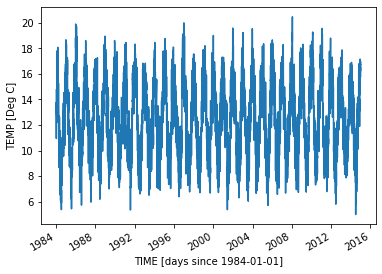

In [171]:
synthclim = hw.synthclim()
synthclim.plot()

In [180]:
synthclim

<xarray.DataArray 'TEMP' (TIME: 11323)>
array([12.91228208, 13.27754476, 13.49649298, ..., 16.6899987 ,
       16.97411213, 15.78684586])
Coordinates:
  * TIME       (TIME) datetime64[ns] 1984-01-01 1984-01-02 ... 2014-12-31
    year       (TIME) int64 1984 1984 1984 1984 1984 ... 2014 2014 2014 2014
    dayofyear  (TIME) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365 366
Attributes:
    units:    Deg C

In [179]:
%%time
orig = hw.detect(synthclim,smoothPercentile=True)


Wall time: 2.71 s


In [173]:
%%time
clim =hw.ts2clm(synthclim,smoothPercentile=True)

Wall time: 78.3 ms


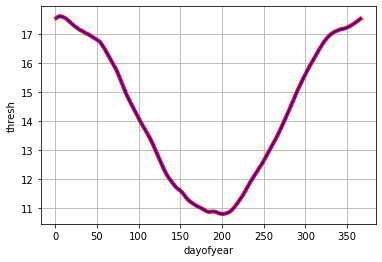

In [191]:
clim =hw.ts2clm(synthclim,smoothPercentile=True)
#(clim.seas[50:70]).plot()
(clim.thresh).plot(color='r',linewidth=4)
#orig.seas[50:70].plot()
(orig.thresh).plot(color='b')
plt.grid(True)

In [188]:
sc =(synthclim.groupby('dayofyear')-clim)

In [193]:
synthclim

<xarray.DataArray 'TEMP' (TIME: 11323)>
array([12.91228208, 13.27754476, 13.49649298, ..., 16.6899987 ,
       16.97411213, 15.78684586])
Coordinates:
  * TIME       (TIME) datetime64[ns] 1984-01-01 1984-01-02 ... 2014-12-31
    year       (TIME) int64 1984 1984 1984 1984 1984 ... 2014 2014 2014 2014
    dayofyear  (TIME) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365 366
Attributes:
    units:    Deg C

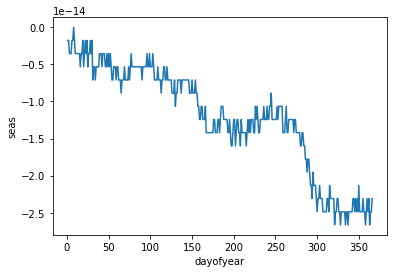

In [167]:
(clim.seas-orig.seas).plot()

In [165]:
# Generate time vector using datetime format (January 1 of year 1 is day 1)
t = np.arange(date(1982,1,1).toordinal(),date(2014,12,31).toordinal()+1)
dates = [date.fromordinal(tt.astype(int)) for tt in t]
# Generate synthetic temperature time series
sst = np.zeros(len(t))
sst[0] = 0 # Initial condition
a = 0.85 # autoregressive parameter
for i in range(1,len(t)):
    sst[i] = a*sst[i-1] + 0.75*np.random.randn() + 0.5*np.cos(t[i]*2*np.pi/365.25)
sst = sst - sst.min() + 5.

In [31]:
%%time
mhws, clim = detect(t, sst, smoothPercentile=True)

NameError: name 't' is not defined

In [522]:
mhws['n_events']

76

In [505]:
ev = np.argmax(mhws['intensity_max']) # Find largest event
print ('Maximum intensity:', mhws['intensity_max'][ev], 'deg. C')
print ('Average intensity:', mhws['intensity_mean'][ev], 'deg. C')
print ('Cumulative intensity:', mhws['intensity_cumulative'][ev], 'deg. C-days')
print ('Duration:', mhws['duration'][ev], 'days')
print ('Start date:', mhws['date_start'][ev].strftime("%d %B %Y"))
print ('End date:', mhws['date_end'][ev].strftime("%d %B %Y"))

Maximum intensity: 5.263057402953802 deg. C
Average intensity: 3.8361964094956034 deg. C
Cumulative intensity: 42.198160504451636 deg. C-days
Duration: 11 days
Start date: 01 February 1994
End date: 11 February 1994


Text(0, 0.5, 'SST [$^\\circ$C]')

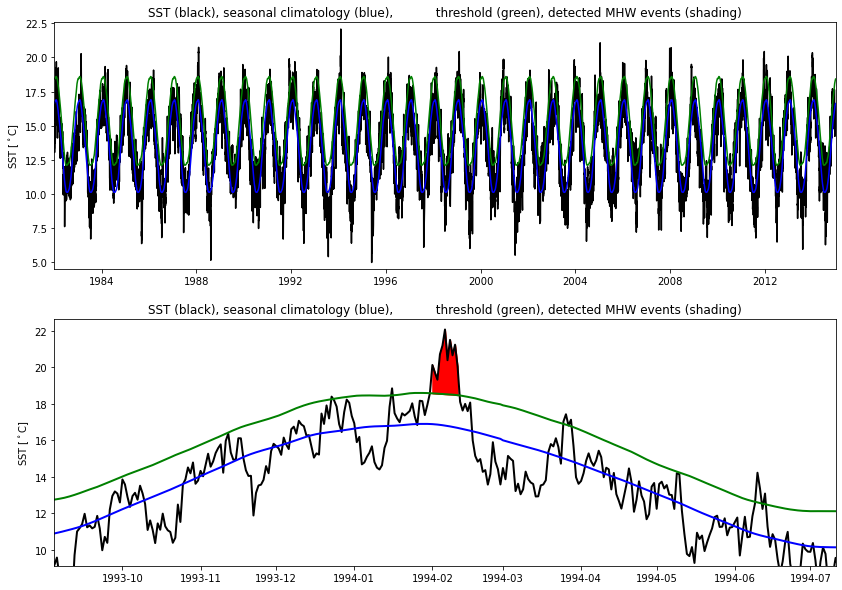

In [506]:
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
# Plot SST, seasonal cycle, and threshold
plt.plot(dates, sst, 'k-')
plt.plot(dates, clim['thresh'], 'g-')
plt.plot(dates, clim['seas'], 'b-')
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
plt.xlim(dates[0], dates[-1])
plt.ylim(sst.min()-0.5, sst.max()+0.5)
plt.ylabel(r'SST [$^\circ$C]')
plt.subplot(2,1,2)
# Find indices for all ten MHWs before and after event of interest and shade accordingly
for ev0 in np.arange(ev-10, ev+11, 1):
    t1 = np.where(t==mhws['time_start'][ev0])[0][0]
    t2 = np.where(t==mhws['time_end'][ev0])[0][0]
    plt.fill_between(dates[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], \
                     color=(1,0.6,0.5))
# Find indices for MHW of interest and shade accordingly
t1 = np.where(t==mhws['time_start'][ev])[0][0]
t2 = np.where(t==mhws['time_end'][ev])[0][0]
plt.fill_between(dates[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], \
                 color='r')
# Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
plt.plot(dates, sst, 'k-', linewidth=2)
plt.plot(dates, clim['thresh'], 'g-', linewidth=2)
plt.plot(dates, clim['seas'], 'b-', linewidth=2)
plt.title('SST (black), seasonal climatology (blue), \
          threshold (green), detected MHW events (shading)')
plt.xlim(date.fromordinal(mhws['time_start'][ev]-150), date.fromordinal(mhws['time_end'][ev]+150))
plt.ylim(clim['seas'].min() - 1, clim['seas'].max() + mhws['intensity_max'][ev] + 0.5)
plt.ylabel(r'SST [$^\circ$C]')

In [634]:
import xarray as xr


vfunc = np.vectorize(lambda x:np.datetime64(x))

temp = xr.DataArray(sst,dims=['TIME'],coords={'TIME':vfunc(dates)})
temp.coords['year']=temp.TIME.dt.year
temp.coords['dayofyear']=temp.TIME.dt.dayofyear
#temp.coords['dayofyear']=xr.where((temp.dayofyear==60) & (~temp.TIME.dt.is_leap_year),np.nan,temp.dayofyear)
#temp.coords['dayofyear']=xr.where((temp.dayofyear>59) & (~temp.TIME.dt.is_leap_year),temp.dayofyear-1,temp.dayofyear)
temp = xr.where((temp.dayofyear==60) & (temp.TIME.dt.is_leap_year),np.nan,temp)
def rle(inarray,minlength=5):
        """ run length encoding. Partial credit to R rle function. 
            Multi datatype arrays catered for including non Numpy
            returns: tuple (runlengths, startpositions, values) """
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = np.array(ia[1:] != ia[:-1])     # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)   # must include last element posi
            z = np.diff(np.append(-1, i))       # run lengths
            p = np.cumsum(np.append(0, z))[:-1] # positions
            z =z[ia[i]]
            p =p[ia[i]]
            
            mask = (z>=minlength)
            print(minlength)
            z = z[mask]
            p =p[mask]
            return(z, p)

# calculate the clim
def ts2clm(ts,percentile=90):
    #lets make Feb 29th on the non leap years 
    ts =ts.set_index(TIME=['dayofyear','year']).unstack()
    #.interpolate_na(dim='dayofyear',max_gap=2)
    #interp Feb 29th
    #ts =ts.ffill(dim='dayofyear')
    t1 =ts.pad(dayofyear=31, mode='wrap').rolling(dayofyear=11,min_periods=1,center=True).construct("window_dim")
    seas =t1.reduce(np.nanmean,dim=('year','window_dim')) #.rolling(dayofyear=31,center=True).mean()
    seas = xr.where(seas.dayofyear==60,np.nan,seas)[31:-31].interpolate_na(dim='dayofyear',max_gap=2)
    seas = seas.pad(dayofyear=31, mode='wrap').rolling(dayofyear=32,center=True).mean()[31:-31]
    thresh = t1.reduce(np.nanpercentile,dim=('year','window_dim'), q=percentile) #
    thresh = xr.where(thresh.dayofyear==60,np.nan,thresh)[31:-31].interpolate_na(dim='dayofyear',max_gap=2)
    thresh = thresh.pad(dayofyear=31, mode='wrap').rolling(dayofyear=32,center=True).mean()[31:-31]
    ds = xr.Dataset({'seas':seas,'thresh':thresh})
    return ds,ts


# return the number of heat waves

def detect1(ts,clim,minDuration=5):
    exceed_bool = (ts.groupby('dayofyear')-clim)>0
    runs, index =rle(exceed_bool,minDuration)
    return runs, index


clim1,ts =ts2clm(temp)
a,b =detect1(temp,clim1['thresh'],minDuration=5)

print(f"total count {len(a)}")

5
total count 77


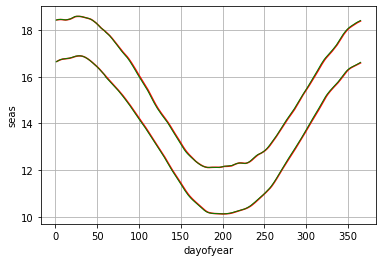

In [636]:
clim1['thresh'][1:365].plot(color='red')
clim1['seas'][1:365].plot(color='red')
plt.plot(range(1,366),clim['thresh'][0:365], 'g-', linewidth=1)
plt.plot(range(1,366),clim['seas'][0:365], 'g-', linewidth=1)


plt.grid(True)